# Final Pipeline to classifiy Disaster Response Messages

This projects consists of an ETL Pipeline and an ML Pipeline.
- The **ETL** part uses two CSV files and outputs a cleaned df and saves to an SQL database.
- The **ML pipeline** loads from the SQL database, initializes independent (X) and dependent variables (y),
does a train-test-split and then uses a multioutput randomforest classifier together with a TF-IDF transformer to classify 'disaster response messages' in 36 categories, e.g. "aid_related", "search_and_rescue", "food" or "water.

### Data from:

https://www.figure-eight.com/dataset/combined-disaster-response-data/

In [1]:
# import libraries
import pandas as pd
import sqlite3
from sqlalchemy import create_engine

messages = pd.read_csv('messages.csv')
categories = pd.read_csv('categories.csv')

# merge datasets
df = pd.merge(messages, categories, on='id', how='left')


# create a dataframe of the 36 individual category columns
#categories = categories.reindex(categories.columns.tolist() + ['col_'+str(i) for i in range(1,37)], axis=1)
categories = df.categories.str.split(';',expand=True)


# select the first row of the categories dataframe
row = categories.iloc[0,:]

# use this row to extract a list of new column names for categories.
# one way is to apply a lambda function that takes everything 
# up to the second to last character of each string with slicing
category_colnames = [element.split('-')[0] for element in row]

# rename the columns of `categories`
categories.columns = category_colnames


for column in categories:
    # set each value to be the last character of the string
    categories[column] = categories[column].astype(str).str.split('-')
    categories[column] = categories[column].astype(list).str[1]
    
    # convert column from string to numeric
    categories[column] = categories[column].astype(int)

#drop the original categories column    
df = df.drop('categories', axis = 1)

# concatenate the original dataframe with the new `categories` dataframe
df = pd.concat([df, categories], axis=1)

# drop duplicates
df = df.drop_duplicates()
#keep only 'related' < 2
df = df[df['related'] < 2]

#save as SQLite database:
engine = create_engine('sqlite:///DisasterResponseLuke.db')
df.to_sql('CleanDataset', engine, index=False, if_exists='replace')
#df.to_csv('DisasterResponseLuke.csv',)

### 8. Use this notebook to complete `etl_pipeline.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database based on new datasets specified by the user. Alternatively, you can complete `etl_pipeline.py` in the classroom on the `Project Workspace IDE` coming later.

In [6]:
#---EDITED---

# import packages & libraries
import sys
from functools import partial

import pandas as pd
import sqlite3
from sqlalchemy import create_engine

import pickle
import pandas as pd
import numpy as np


import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import precision_recall_fscore_support
from collections import defaultdict

from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

#for ROC/AUC:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot
%matplotlib inline

#-----
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
#-----






def load_data(data_file1, data_file2):
    # read in file
    # clean data
    # load to database
    # define features and label arrays


    messages = pd.read_csv(data_file1)
    categories = pd.read_csv(data_file2)

    # merge datasets
    df = pd.merge(messages, categories, on='id', how='left')


    # create a dataframe of the 36 individual category columns
    #categories = categories.reindex(categories.columns.tolist() + ['col_'+str(i) for i in range(1,37)], axis=1)
    categories = df.categories.str.split(';',expand=True)


    # select the first row of the categories dataframe
    row = categories.iloc[0,:]

    # use this row to extract a list of new column names for categories.
    # one way is to apply a lambda function that takes everything 
    # up to the second to last character of each string with slicing
    category_colnames = [element.split('-')[0] for element in row]

    # rename the columns of `categories`
    categories.columns = category_colnames


    for column in categories:
        # set each value to be the last character of the string
        categories[column] = categories[column].astype(str).str.split('-')
        categories[column] = categories[column].astype(list).str[1]

        # convert column from string to numeric
        categories[column] = categories[column].astype(int)

    #drop the original categories column    
    df = df.drop('categories', axis = 1)

    # concatenate the original dataframe with the new `categories` dataframe
    df = pd.concat([df, categories], axis=1)

    # drop duplicates
    df = df.drop_duplicates()
    #keep only 'related' < 2
    df = df[df['related'] < 2]

    #save as SQLite database:
    engine = create_engine('sqlite:///DisasterResponseLuke.db')
    df.to_sql('CleanDataset', engine, index=False, if_exists='replace')
    #df.to_csv('DisasterResponseLuke.csv',)




    # load data from database
    engine = create_engine('sqlite:///DisasterResponseLuke.db')
    df = pd.read_sql("SELECT * FROM CleanDataset", engine)
    X = df.message.values
    y = df.drop(['id','message','original','genre'], axis=1).values

    return df, X, y




def build_model():
    # text processing and model pipeline
    # define parameters for GridSearchCV
    # create gridsearch object and return as final model pipeline
    '''
    def tokenize(text):
        # normalize case and remove punctuation
        text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

        # tokenize text
        tokens = word_tokenize(text)

        # lemmatize andremove stop words
        clean_tokens = [lemmatizer.lemmatize(word).strip() for word in tokens if word not in stop_words]

        return clean_tokens
    '''

    #build pipeline
    model = Pipeline([
        ('vect', CountVectorizer(tokenizer=partial(tokenize))),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier()))
        ])
    
    model.set_params(
        vect__ngram_range = (1, 1),       #(1, 1)
        vect__max_df = 1.0,            #1.0
        vect__max_features = 10000,   #10000
        tfidf__use_idf = False,             #False
        clf__estimator__n_estimators = 100,  #n_estimators = number of trees in the foreset
        clf__estimator__min_samples_split = 2, #2 #min_samples_split = min number of data points placed in a node before the node is split
    )
    
    return model





def train(X, y, model):
    # train test split
    # fit model
    # output model test results
    


    #train, test, split data
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # train classifier
    model.fit(X_train, y_train)
    
    # predict on test data
    y_pred = model.predict(X_test)
    model_probs = model.predict_proba(X_test)

    
    return model, y_pred, model_probs, X_train, X_test, y_train, y_test
    

def export_model(model, y_pred, model_probs, X_train, X_test, y_train, y_test, df, X, y):
    # Export model as a pickle file
    
    to_store = (model, y_pred, model_probs, X_train, X_test, y_train, y_test, df, X, y)

    file_Name = "DisasterResponseModelLuke.pkl"

    # open the file for writing
    #fileObject = open(file_Name,'wb') 

    # this writes the object to the file named 'DisasterResponseModelLuke'
    #pickle.dump(to_store,fileObject)  
    
    with open(file_Name, 'wb') as file:
        pickle.dump(to_store, file)
        
    # here we close the fileObject
    #fileObject.close()


    
def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

    # tokenize text
    tokens = word_tokenize(text)

    # lemmatize andremove stop words
    clean_tokens = [lemmatizer.lemmatize(word).strip() for word in tokens if word not in stop_words]

    return clean_tokens

def run_pipeline(data_file1, data_file2):
    #load data
    df, X, y = load_data(data_file1, data_file2)  # run ETL pipeline
    model = build_model()  # build model pipeline
    
    # train model pipeline and generate storage
    model, y_pred, model_probs, X_train, X_test, y_train, y_test = train(X, y, model)
    # save model as pickel
    export_model(model, y_pred, model_probs, X_train, X_test, y_train, y_test, df, X, y)
    
if __name__ == '__main__':
    #data_file = sys.argv[1]  # get filename of dataset
    data_file1 = "messages.csv"
    data_file2 = "categories.csv"
    run_pipeline(data_file1, data_file2)  # run data pipeline


def run():
    data_file1 = "messages.csv"
    data_file2 = "categories.csv"
    run_pipeline(data_file1, data_file2)  # run data pipeline

run()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [7]:
# we open the file for reading
file_Name = "DisasterResponseModelLuke.pkl"
fileObject = open(file_Name,'rb')

# load the object from the file into var b
pickled_model, pickled_y_pred, pickled_model_probs, pickled_X_train, pickled_X_test, pickled_y_train, pickled_y_test, pickled_df, pickled_X, pickled_y = pickle.load(fileObject)

Category: related
Labels: [0 1]
Confusion Matrix:
 [[ 646  820]
 [ 249 4792]]
Accuracy: 0.835715383433


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.72      0.44      0.55      1466
          1       0.85      0.95      0.90      5041

avg / total       0.82      0.84      0.82      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.867


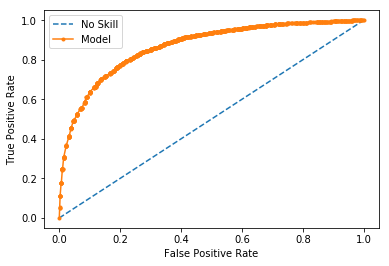

Category: request
Labels: [0 1]
Confusion Matrix:
 [[5216  120]
 [ 585  586]]
Accuracy: 0.891655140618


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.90      0.98      0.94      5336
          1       0.83      0.50      0.62      1171

avg / total       0.89      0.89      0.88      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.671


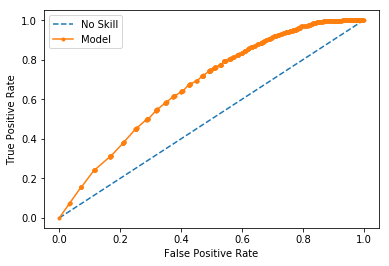

Category: offer
Labels: [0]
Confusion Matrix:
 [[6477]]
Accuracy: 0.995389580452


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6477
          1       0.00      0.00      0.00        30

avg / total       0.99      1.00      0.99      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.575


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


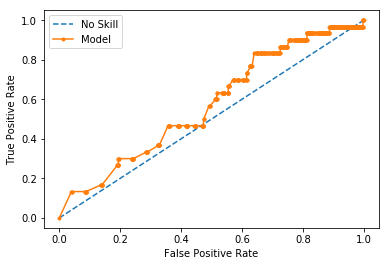

Category: aid_related
Labels: [0 1]
Confusion Matrix:
 [[3061  665]
 [ 776 2005]]
Accuracy: 0.778546181036


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.80      0.82      0.81      3726
          1       0.75      0.72      0.74      2781

avg / total       0.78      0.78      0.78      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.758


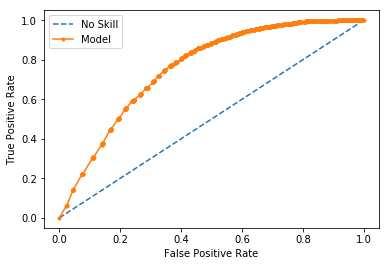

Category: medical_help
Labels: [0 1]
Confusion Matrix:
 [[5925   45]
 [ 471   66]]
Accuracy: 0.920700783771


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.93      0.99      0.96      5970
          1       0.59      0.12      0.20       537

avg / total       0.90      0.92      0.90      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.670


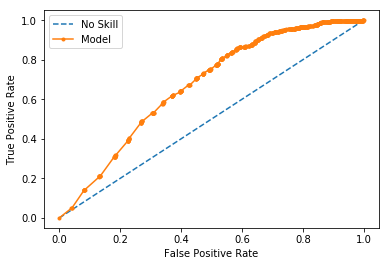

Category: medical_products
Labels: [0 1]
Confusion Matrix:
 [[6136    6]
 [ 319   46]]
Accuracy: 0.950053788228


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      6142
          1       0.88      0.13      0.22       365

avg / total       0.95      0.95      0.93      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.719


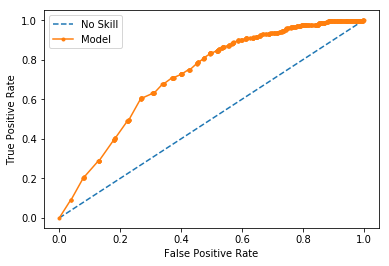

Category: search_and_rescue
Labels: [0 1]
Confusion Matrix:
 [[6335    6]
 [ 153   13]]
Accuracy: 0.975564776395


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      6341
          1       0.68      0.08      0.14       166

avg / total       0.97      0.98      0.97      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.682


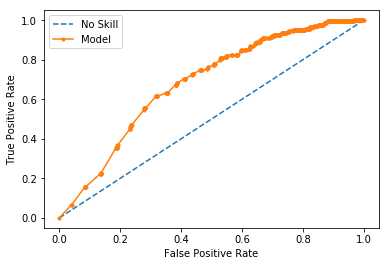

Category: security
Labels: [0 1]
Confusion Matrix:
 [[6402    0]
 [ 104    1]]
Accuracy: 0.984017212233


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      6402
          1       1.00      0.01      0.02       105

avg / total       0.98      0.98      0.98      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.550


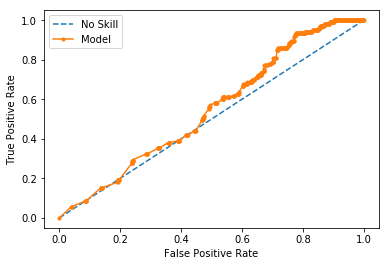

Category: military
Labels: [0 1]
Confusion Matrix:
 [[6287   17]
 [ 180   23]]
Accuracy: 0.969724911634


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.97      1.00      0.98      6304
          1       0.57      0.11      0.19       203

avg / total       0.96      0.97      0.96      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.524


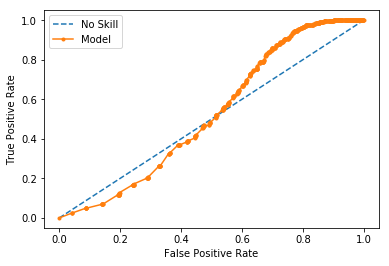

Category: child_alone
Labels: [0]
Confusion Matrix:
 [[6507]]
Accuracy: 1.0


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6507

avg / total       1.00      1.00      1.00      6507

No binary classification possible
/n
Category: water
Labels: [0 1]
Confusion Matrix:
 [[6034   29]
 [ 241  203]]
Accuracy: 0.958506224066


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      6063
          1       0.88      0.46      0.60       444

avg / total       0.96      0.96      0.95      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.751


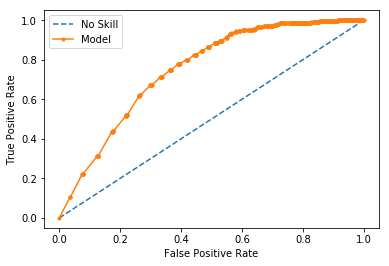

Category: food
Labels: [0 1]
Confusion Matrix:
 [[5655  109]
 [ 220  523]]
Accuracy: 0.949439065622


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.98      0.97      5764
          1       0.83      0.70      0.76       743

avg / total       0.95      0.95      0.95      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.751


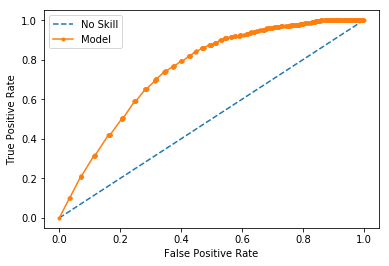

Category: shelter
Labels: [0 1]
Confusion Matrix:
 [[5820   87]
 [ 309  291]]
Accuracy: 0.939142461964


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      5907
          1       0.77      0.48      0.60       600

avg / total       0.93      0.94      0.93      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.758


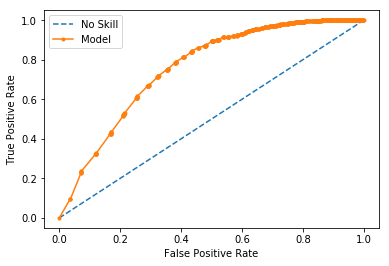

Category: clothing
Labels: [0 1]
Confusion Matrix:
 [[6406    5]
 [  84   12]]
Accuracy: 0.986322422007


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      6411
          1       0.71      0.12      0.21        96

avg / total       0.98      0.99      0.98      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.731


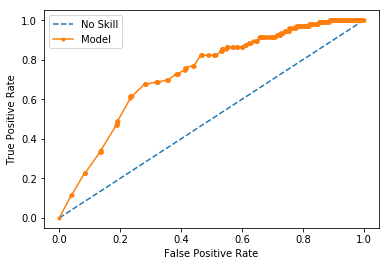

Category: money
Labels: [0 1]
Confusion Matrix:
 [[6344    2]
 [ 154    7]]
Accuracy: 0.976025818349


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      6346
          1       0.78      0.04      0.08       161

avg / total       0.97      0.98      0.97      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.651


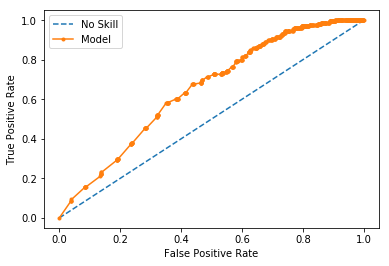

Category: missing_people
Labels: [0 1]
Confusion Matrix:
 [[6426    0]
 [  79    2]]
Accuracy: 0.987859228523


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      6426
          1       1.00      0.02      0.05        81

avg / total       0.99      0.99      0.98      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.650


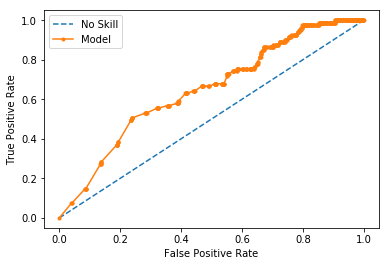

Category: refugees
Labels: [0 1]
Confusion Matrix:
 [[6276    5]
 [ 220    6]]
Accuracy: 0.965421853389


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.97      1.00      0.98      6281
          1       0.55      0.03      0.05       226

avg / total       0.95      0.97      0.95      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.681


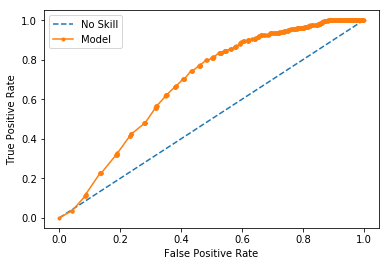

Category: death
Labels: [0 1]
Confusion Matrix:
 [[6207    7]
 [ 230   63]]
Accuracy: 0.963577685569


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      6214
          1       0.90      0.22      0.35       293

avg / total       0.96      0.96      0.95      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.709


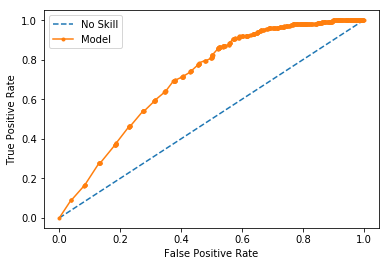

Category: other_aid
Labels: [0 1]
Confusion Matrix:
 [[5555   29]
 [ 892   31]]
Accuracy: 0.858460119871


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.99      0.92      5584
          1       0.52      0.03      0.06       923

avg / total       0.81      0.86      0.80      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.655


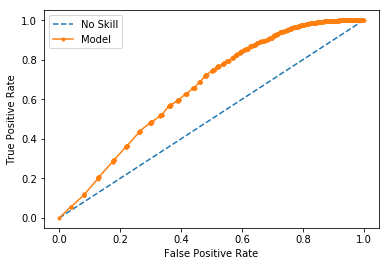

Category: infrastructure_related
Labels: [0 1]
Confusion Matrix:
 [[6037    6]
 [ 462    2]]
Accuracy: 0.928077455048


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.93      1.00      0.96      6043
          1       0.25      0.00      0.01       464

avg / total       0.88      0.93      0.89      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.699


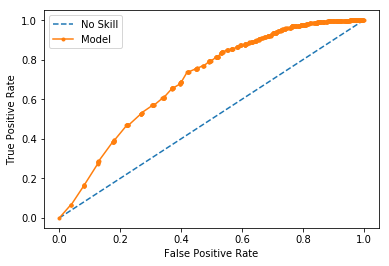

Category: transport
Labels: [0 1]
Confusion Matrix:
 [[6187   13]
 [ 274   33]]
Accuracy: 0.955893652989


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      6200
          1       0.72      0.11      0.19       307

avg / total       0.95      0.96      0.94      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.660


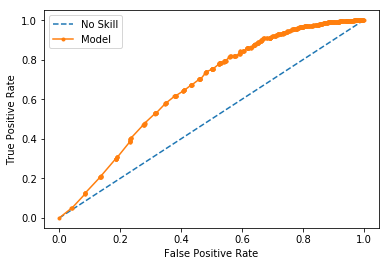

Category: buildings
Labels: [0 1]
Confusion Matrix:
 [[6134   14]
 [ 311   48]]
Accuracy: 0.950053788228


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      6148
          1       0.77      0.13      0.23       359

avg / total       0.94      0.95      0.93      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.724


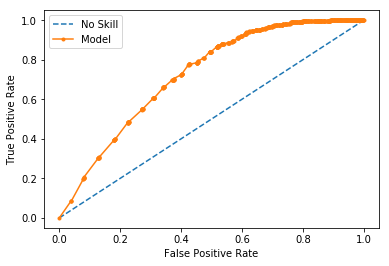

Category: electricity
Labels: [0 1]
Confusion Matrix:
 [[6370    2]
 [ 126    9]]
Accuracy: 0.980328876594


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      6372
          1       0.82      0.07      0.12       135

avg / total       0.98      0.98      0.97      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.643


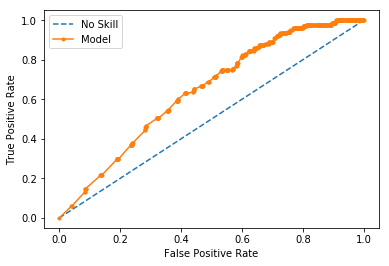

Category: tools
Labels: [0]
Confusion Matrix:
 [[6474]]
Accuracy: 0.994928538497


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      6474
          1       0.00      0.00      0.00        33

avg / total       0.99      0.99      0.99      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.686


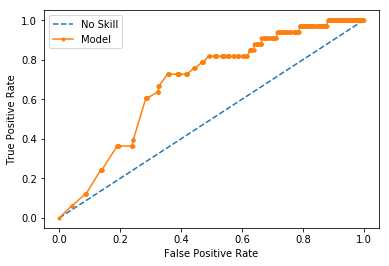

Category: hospitals
Labels: [0]
Confusion Matrix:
 [[6432]]
Accuracy: 0.98847395113


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      6432
          1       0.00      0.00      0.00        75

avg / total       0.98      0.99      0.98      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.656


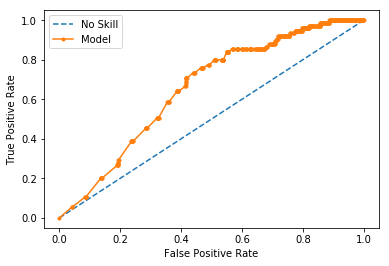

Category: shops
Labels: [0]
Confusion Matrix:
 [[6472]]
Accuracy: 0.994621177194


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      6472
          1       0.00      0.00      0.00        35

avg / total       0.99      0.99      0.99      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.711


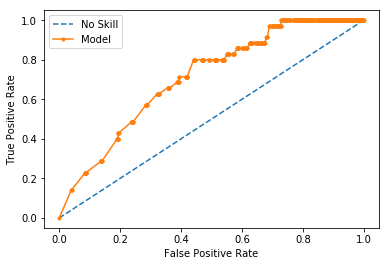

Category: aid_centers
Labels: [0]
Confusion Matrix:
 [[6422]]
Accuracy: 0.986937144613


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      6422
          1       0.00      0.00      0.00        85

avg / total       0.97      0.99      0.98      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.651


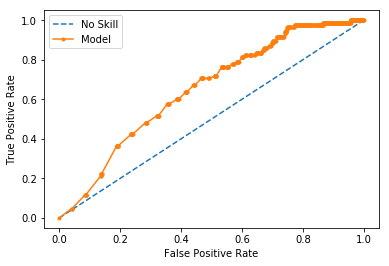

Category: other_infrastructure
Labels: [0 1]
Confusion Matrix:
 [[6188    3]
 [ 316    0]]
Accuracy: 0.950975872138


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      6191
          1       0.00      0.00      0.00       316

avg / total       0.91      0.95      0.93      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.706


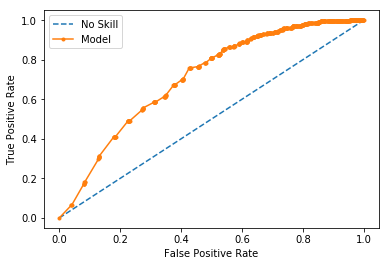

Category: weather_related
Labels: [0 1]
Confusion Matrix:
 [[4418  233]
 [ 538 1318]]
Accuracy: 0.881512217612


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.89      0.95      0.92      4651
          1       0.85      0.71      0.77      1856

avg / total       0.88      0.88      0.88      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.768


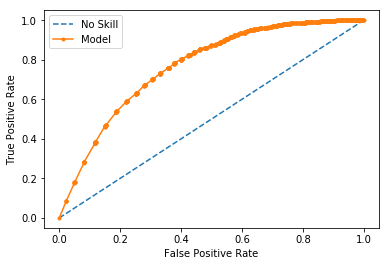

Category: floods
Labels: [0 1]
Confusion Matrix:
 [[5923   27]
 [ 278  279]]
Accuracy: 0.95312740126


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.96      1.00      0.97      5950
          1       0.91      0.50      0.65       557

avg / total       0.95      0.95      0.95      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.741


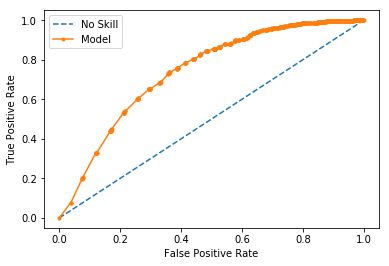

Category: storm
Labels: [0 1]
Confusion Matrix:
 [[5756  116]
 [ 254  381]]
Accuracy: 0.943138158906


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.98      0.97      5872
          1       0.77      0.60      0.67       635

avg / total       0.94      0.94      0.94      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.709


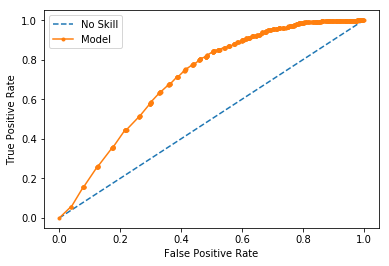

Category: fire
Labels: [0]
Confusion Matrix:
 [[6440]]
Accuracy: 0.989703396342


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      6440
          1       0.00      0.00      0.00        67

avg / total       0.98      0.99      0.98      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.569


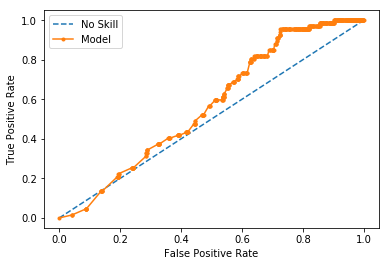

Category: earthquake
Labels: [0 1]
Confusion Matrix:
 [[5836   62]
 [ 117  492]]
Accuracy: 0.972491163363


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      5898
          1       0.89      0.81      0.85       609

avg / total       0.97      0.97      0.97      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.778


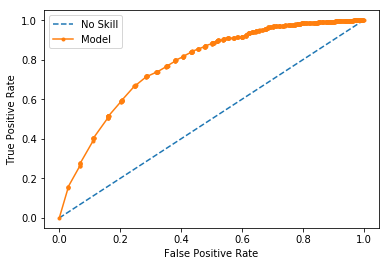

Category: cold
Labels: [0 1]
Confusion Matrix:
 [[6372    6]
 [ 112   17]]
Accuracy: 0.98186568311


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      6378
          1       0.74      0.13      0.22       129

avg / total       0.98      0.98      0.98      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.683


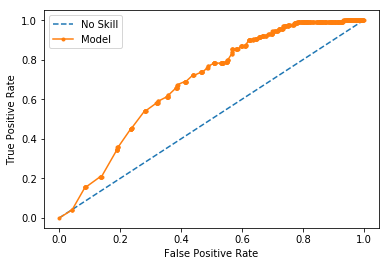

Category: other_weather
Labels: [0 1]
Confusion Matrix:
 [[6139    9]
 [ 346   13]]
Accuracy: 0.94544336868


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      6148
          1       0.59      0.04      0.07       359

avg / total       0.93      0.95      0.92      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.625


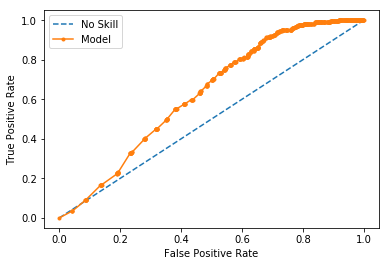

Category: direct_report
Labels: [0 1]
Confusion Matrix:
 [[5072  145]
 [ 804  486]]
Accuracy: 0.854157061626


Sklearn Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.97      0.91      5217
          1       0.77      0.38      0.51      1290

avg / total       0.84      0.85      0.83      6507

No Skill: ROC AUC=0.500
Model: ROC AUC=0.664


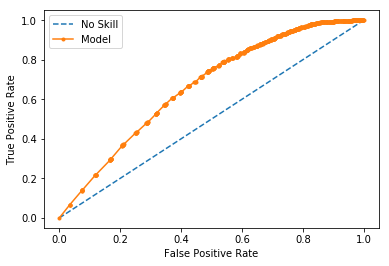

In [10]:
#print("\nBest Parameters:", model.best_params_)
# Step 4: Display results

# Display a confusion matrix and accuracy score 
# based on the model's predictions
# for every category

def display_results(y_te, y_pr):
    
    labels = np.unique(y_pr)
    confusion_mat = confusion_matrix(y_te, y_pr, labels=labels)
    accuracy = (y_pr == y_te).mean()
    report = classification_report(y_te, y_pr)

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)
    print("\n")
    print('Sklearn Classification Report:')
    print(report)
    
    return precision_recall_fscore_support(y_te, y_pr, average = 'weighted') 

    

def graph_results(y_te, model_probs):
    
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_te))]

    # keep probabilities for the positive outcome only
    model_probs = model_probs[0][:, 1]
    
    # calculate scores
    ns_auc = roc_auc_score(y_te, ns_probs)
    lr_auc = roc_auc_score(y_te, model_probs)

    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (lr_auc))
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_te, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_te, model_probs)
    
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    
    # show the legend
    pyplot.legend()
    
    # show the plot
    pyplot.show()
    return lr_auc


d = defaultdict(list)
for column in range(0,pickled_y_pred.shape[1]):
    y_pr_b = pickled_y_pred[:,column]
    y_te_b = pickled_y_test[:,column]
    print('Category: ' + str(pickled_df.columns[4+column]))
    precision, recall, fscore, support = display_results(y_te_b, y_pr_b)

    try:
        lr_auc = graph_results(y_te_b, pickled_model_probs)
    except:
        print("No binary classification possible")
        print('/n')
        
    d['precision'].append(precision)
    d['recall'].append(recall)
    d['fscore'].append(fscore)
    d['ROC AUC'].append(lr_auc)

# Predict on New Data:

In [11]:
new_data = "This is an offer, I can bring you help"

In [13]:
new_array = np.array([new_data], dtype = 'object')
y_pred_0 = pickled_model.predict(new_array[0:1])
categories = pickled_df.drop(['id','message','original','genre'], axis=1).columns
result = pd.DataFrame({'Prediction': y_pred_0[0],
                       'Accuracy (train)': d['precision'],
                       'Recall (train)': d['recall'],
                       'F-Score (train)': d['fscore'],
                       'ROC AUC (train)': d['ROC AUC'],
                      },
                     categories)
result

,Prediction,Accuracy (train),Recall (train),F-Score (train),ROC AUC (train)
related,1,0.824124,0.835715,0.820252,0.867341
request,0,0.886715,0.891655,0.880497,0.671437
offer,0,0.990800,0.995390,0.993090,0.574955
aid_related,1,0.777747,0.778546,0.777917,0.758459
medical_help,0,0.898981,0.920701,0.896001,0.670117
medical_products,0,0.946881,0.950054,0.931929,0.719078
search_and_rescue,0,0.968964,0.975565,0.965997,0.682275
security,0,0.984273,0.984017,0.976241,0.549830
military,0,0.959776,0.969725,0.959764,0.524399
child_alone,0,1.000000,1.000000,1.000000,0.524399
